In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from math import ceil
from tqdm.notebook import tqdm
import wandb
from torch_lr_finder import LRFinder
from utils import EarlyStopping
import utils

In [27]:
run = wandb.init(project='HyperView-initial', reinit=True)
# wandb.init(mode="disabled") # in case of testing code

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jcharyton (use `wandb login --relogin` to force relogin)


### Paths definition

In [2]:
train_data_directory = r'train_data'
test_data_directory = r'test_data'
saved_models_directory = r'saved_models'
submissions_directory = r'submissions'

### Dataset testing

In [3]:
all_files = np.array(
    sorted(
        glob(os.path.join(train_data_directory, 'train_data', "*.npz")),
        key=lambda x: int(os.path.basename(x).replace(".npz", "")),
    )
)

In [4]:
all_files

array(['train_data/train_data/0.npz', 'train_data/train_data/1.npz',
       'train_data/train_data/2.npz', ...,
       'train_data/train_data/1729.npz', 'train_data/train_data/1730.npz',
       'train_data/train_data/1731.npz'], dtype='<U30')

In [64]:
arr = np.ma.MaskedArray(**np.load(all_files[1454]))
arr.shape

(150, 93, 115)

In [80]:
arr.shape[1], arr.shape[2]

(93, 115)

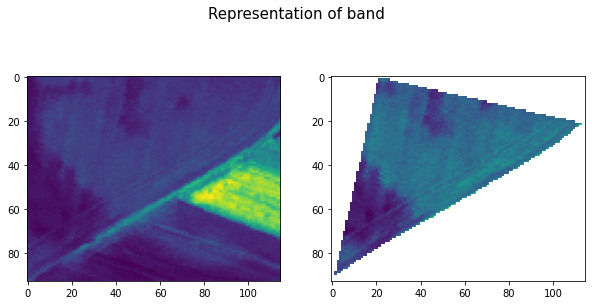

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 145

axs[0].imshow(arr[band_id,:,:].data)
axs[1].imshow(arr[band_id,:,:])
plt.suptitle(f'Representation of band', fontsize=15)
plt.show()

In [65]:
tensor_data = torch.as_tensor(arr)
tensor_data

tensor([[[ 275,  268,  279,  ...,  309,  338,  281],
         [ 250,  261,  276,  ...,  357,  336,  365],
         [ 243,  251,  251,  ...,  337,  295,  304],
         ...,
         [ 363,  359,  354,  ...,  268,  275,  268],
         [ 381,  345,  378,  ...,  295,  284,  287],
         [ 398,  428,  424,  ...,  297,  296,  318]],

        [[ 271,  270,  274,  ...,  308,  342,  283],
         [ 255,  262,  277,  ...,  357,  338,  372],
         [ 250,  251,  250,  ...,  338,  295,  301],
         ...,
         [ 366,  359,  360,  ...,  264,  269,  265],
         [ 377,  351,  384,  ...,  296,  283,  288],
         [ 402,  434,  433,  ...,  296,  302,  315]],

        [[ 266,  267,  264,  ...,  299,  341,  280],
         [ 254,  261,  275,  ...,  353,  331,  375],
         [ 251,  246,  249,  ...,  334,  289,  302],
         ...,
         [ 365,  356,  357,  ...,  258,  266,  257],
         [ 378,  348,  380,  ...,  292,  279,  284],
         [ 403,  432,  427,  ...,  296,  299,  319]],

In [66]:
tensor_data.shape

torch.Size([150, 93, 115])

In [67]:
tensor_mask_bool = torch.as_tensor(arr.mask)
tensor_mask_bool

tensor([[[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True, False, False,  ...,  True,  True,  True],
         [ True, False,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True, False, False,  ...,  True,  True,  True],
         [ True, False,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True, False, False,  ...,  True,  True,  True],
         [

In [73]:
tensor_mask_bool.shape

torch.Size([150, 93, 115])

In [177]:
tensor_data_masked = torch.mul(tensor_data, tensor_mask_bool)
tensor_data_masked

tensor([[[ 275,  268,  279,  ...,  309,  338,  281],
         [ 250,  261,  276,  ...,  357,  336,  365],
         [ 243,  251,  251,  ...,  337,  295,  304],
         ...,
         [ 363,    0,    0,  ...,  268,  275,  268],
         [ 381,    0,  378,  ...,  295,  284,  287],
         [ 398,  428,  424,  ...,  297,  296,  318]],

        [[ 271,  270,  274,  ...,  308,  342,  283],
         [ 255,  262,  277,  ...,  357,  338,  372],
         [ 250,  251,  250,  ...,  338,  295,  301],
         ...,
         [ 366,    0,    0,  ...,  264,  269,  265],
         [ 377,    0,  384,  ...,  296,  283,  288],
         [ 402,  434,  433,  ...,  296,  302,  315]],

        [[ 266,  267,  264,  ...,  299,  341,  280],
         [ 254,  261,  275,  ...,  353,  331,  375],
         [ 251,  246,  249,  ...,  334,  289,  302],
         ...,
         [ 365,    0,    0,  ...,  258,  266,  257],
         [ 378,    0,  380,  ...,  292,  279,  284],
         [ 403,  432,  427,  ...,  296,  299,  319]],

In [178]:
tensor_data_masked.shape

torch.Size([150, 93, 115])

In [285]:
def pad_to_minimum_size(min_size, image):
        c, h, w = image.shape
        h_diff = (min_size - h)/2
        w_diff = (min_size - w)/2
        print(h_diff, w_diff)
        
        if not h_diff.is_integer():
            h_pad1 = int(h_diff - 0.5)
            h_pad2 = int(h_diff + 0.5)
        else:
            h_pad1 = h_pad2 = int(h_diff)

        if not w_diff.is_integer():
            w_pad1 = int(w_diff - 0.5)
            w_pad2 = int(w_diff + 0.5)
        else:
            w_pad1 = w_pad2 = int(w_diff)
        
        print(h_pad1, h_pad2, w_pad1, w_pad2)
        # check if any padding is bigger than zero
        if h_pad1+h_pad2+w_pad1+h_pad2 == 0:
            return image
        else:
            return transforms.functional.pad(image, (w_pad1, h_pad1, w_pad2, h_pad2), fill=0)
    

In [286]:
pad_to_minimum_size(300, tensor_data_masked).shape

103.5 92.5
103 104 92 93


torch.Size([150, 300, 300])

### Load mean and std values of training dataset

In [3]:
means_stds_arrays = np.load(os.path.join(train_data_directory, 'means_stds_values_training_data.npz'))
means = np.array(means_stds_arrays['means'])
stds = np.array(means_stds_arrays['stds'])

In [23]:
tensor_data_masked_normalized = transforms.functional.normalize(torch.as_tensor(tensor_data_masked, dtype=torch.float), mean=means.tolist(), std=stds.tolist())
tensor_data_masked_normalized

NameError: name 'tensor_data_masked' is not defined

In [20]:
temp_gt = pd.read_csv(os.path.join(train_data_directory, 'train_gt.csv'))[['P','K','Mg','pH']]

In [22]:
temp_gt

P      K     Mg   pH
0     45.1  188.0  179.0  7.2
1     44.8  205.0  188.0  7.0
2     44.4  207.0  145.0  6.8
3     46.5  204.0  143.0  6.8
4     52.0  212.0  167.0  6.7
...    ...    ...    ...  ...
1727  40.8  133.0  132.0  6.2
1728  42.7  192.0  126.0  6.5
1729  39.4  180.0  122.0  6.5
1730  37.3  162.0  127.0  6.5
1731  29.5  146.0  133.0  6.3

[1732 rows x 4 columns]

In [25]:
temp_gt.loc[1, 'P']

44.8

### Dataset definition

In [4]:
class HyperViewDataset(Dataset):
    def __init__(self, gt_file, img_dir, transform=None, means=None, stds=None):
        self.img_dir = img_dir
        if gt_file is not None:
            self.gt = pd.read_csv(gt_file)[['P','K','Mg','pH']]
        else:
            self.gt = None
        self.transform = transform # whether to perform transformation of input data
        self.means = means # mean values for every band used to normalize data
        self.stds = stds # std values for every band used to normalize data
        
        self.img_files = np.array(
            sorted(
                glob(os.path.join(img_dir, "*.npz")),
                key=lambda x: int(os.path.basename(x).replace(".npz", "")),
            )
        )
    
    def pad_to_minimum_size(self, min_size, image):
        # pads numpy array to defined in `min_size` minimum size of array (w, h)
        c, h, w = image.shape
        h_diff = (min_size - h)/2
        w_diff = (min_size - w)/2
        
        if not h_diff.is_integer():
            h_pad1 = int(h_diff - 0.5)
            h_pad2 = int(h_diff + 0.5)
        else:
            h_pad1 = h_pad2 = int(h_diff)

        if not w_diff.is_integer():
            w_pad1 = int(w_diff - 0.5)
            w_pad2 = int(w_diff + 0.5)
        else:
            w_pad1 = w_pad2 = int(w_diff)
        
        # check if any padding is bigger than zero
        if h_pad1+h_pad2+w_pad1+h_pad2 == 0:
            return image
        else:
            return transforms.functional.pad(image, (w_pad1, h_pad1, w_pad2, h_pad2), fill=0)
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        # load hyperspectral image to array
        img_arr = np.ma.MaskedArray(**np.load(self.img_files[idx]))
        img_tensor = torch.as_tensor(img_arr.data, dtype=torch.float)
        img_tensor_mask = torch.as_tensor(img_arr.mask)
        img_masked_tensor = torch.mul(img_tensor, img_tensor_mask)
        
        if self.transform:
            img_masked_tensor_normalized = transforms.functional.normalize(img_masked_tensor, mean=self.means.tolist(), std=self.stds.tolist())
            img_masked_tensor_normalized_padded = self.pad_to_minimum_size(300, img_masked_tensor_normalized)
            img_result_tensor = img_masked_tensor_normalized_padded
        else:
            img_result_tensor = img_masked_tensor
        # load labels
        if self.gt is not None:
            P_gt = self.gt.loc[idx, 'P']
            K_gt = self.gt.loc[idx, 'K']
            Mg_gt = self.gt.loc[idx, 'Mg']
            pH_gt = self.gt.loc[idx, 'pH']

            sample = {'image': img_result_tensor, 'P': P_gt, 'K': K_gt, 'Mg': Mg_gt, 'pH': pH_gt}
        else:
            sample = {'image': img_result_tensor}
        
        return sample

In [5]:
train_data_whole = HyperViewDataset(os.path.join(train_data_directory, 'train_gt.csv'), os.path.join(train_data_directory, 'train_data'), True, means, stds)

In [6]:
train_dataset, validation_dataset = random_split(train_data_whole, [1400, 332])

### Model Definition

In [7]:
import torchvision
from torchvision import datasets, models, transforms

In [8]:
class ResNext(nn.Module):
    def __init__(self, pretrained):
        super().__init__()
        self.resnext = models.resnext101_32x8d(pretrained=pretrained)
        self.resnext.conv1 = nn.Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnext.fc = nn.Linear(in_features=2048, out_features=4, bias=True)
        
    def forward(self, x):
        x = self.resnext(x)
#         return {'P': x[0], 'K': x[1], 'Mg': x[2], 'pH': x[3]}
        return x

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
BATCH_SIZE = 12
EPOCHS = 300

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=2)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=2)

### Overfitting on single batch of data

In [38]:
model = ResNext(pretrained=False)
model.to(device)

ResNext(
  (resnext): ResNet(
    (conv1): Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seq

In [39]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [14]:
train_data_single_batch = next(iter(train_dataloader))

In [41]:
train_data_single_batch

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...

In [42]:
train_data_single_batch['image'][0].shape

torch.Size([150, 300, 300])

In [43]:
train_data_single_batch['image'].to(device, dtype=torch.float).shape

torch.Size([12, 150, 300, 300])

In [44]:
output = model(train_data_single_batch['image'].to(device, dtype=torch.float))

In [45]:
output

tensor([[-0.3313,  0.0845,  0.4666,  0.4985],
        [-0.1278, -0.0529,  0.2890,  0.0172],
        [-0.1330,  0.2687,  0.4797,  0.6626],
        [-0.1025, -0.1061,  0.3244,  0.0381],
        [-0.1908, -0.0460,  0.2802,  0.1371],
        [-0.1415, -0.1232,  0.2609, -0.0487],
        [-0.0747,  0.1443,  0.4392,  0.3036],
        [-0.4141,  0.4793,  0.8093,  1.2416],
        [-0.1545, -0.1008,  0.3353,  0.0522],
        [-0.2947,  0.1728,  0.4830,  0.6335],
        [-0.1773,  0.1233,  0.2803,  0.3185],
        [-0.1964, -0.1082,  0.2595,  0.0713]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [46]:
stacked_gt = torch.stack((train_data_single_batch['P'], train_data_single_batch['K'], train_data_single_batch['Mg'], train_data_single_batch['pH']))
stacked_gt

tensor([[133.0000, 112.0000,  55.0000,  25.2000,  72.9000,  27.4000,  82.8000,
          83.2000,  61.9000,  46.1000,  44.1000,  74.9000],
        [272.0000, 225.0000, 282.0000, 183.0000, 187.0000, 133.0000, 218.0000,
         211.0000, 255.0000, 234.0000, 167.0000, 202.0000],
        [187.0000, 125.0000, 166.0000, 167.0000, 158.0000, 149.0000, 172.0000,
         148.0000, 137.0000, 227.0000, 126.0000, 129.0000],
        [  7.2000,   7.0000,   6.9000,   7.2000,   6.5000,   6.0000,   6.8000,
           6.7000,   7.0000,   6.4000,   6.9000,   7.0000]],
       dtype=torch.float64)

In [47]:
stacked_gt = stacked_gt.transpose(0, 1).to(device)

In [48]:
stacked_gt

tensor([[133.0000, 272.0000, 187.0000,   7.2000],
        [112.0000, 225.0000, 125.0000,   7.0000],
        [ 55.0000, 282.0000, 166.0000,   6.9000],
        [ 25.2000, 183.0000, 167.0000,   7.2000],
        [ 72.9000, 187.0000, 158.0000,   6.5000],
        [ 27.4000, 133.0000, 149.0000,   6.0000],
        [ 82.8000, 218.0000, 172.0000,   6.8000],
        [ 83.2000, 211.0000, 148.0000,   6.7000],
        [ 61.9000, 255.0000, 137.0000,   7.0000],
        [ 46.1000, 234.0000, 227.0000,   6.4000],
        [ 44.1000, 167.0000, 126.0000,   6.9000],
        [ 74.9000, 202.0000, 129.0000,   7.0000]], device='cuda:0',
       dtype=torch.float64)

In [49]:
loss_func(output, stacked_gt)

tensor(19677.3025, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)

In [15]:
img_data_device = train_data_single_batch['image'].to(device, dtype=torch.float)
stacked_gt_device = torch.stack((train_data_single_batch['P'], train_data_single_batch['K'], train_data_single_batch['Mg'], train_data_single_batch['pH'])).transpose(0,1).to(device, 
    dtype=torch.float)

model = ResNext(False).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

for epoch in range(301):
    model.train()
    
    output = model(img_data_device)
    loss = loss_func(output, stacked_gt_device)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    output_cpu = output.detach().cpu().numpy()
    stacked_gt_cpu = stacked_gt_device.cpu().numpy()

    # Calculate MSE for each class
    mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
    
    if epoch%10 == 0:
        print(f'epoch: {epoch}, loss: {loss.data.cpu().numpy()}, MSE: {mse}')

epoch: 0, loss: 17285.615234375, MSE: [3.8184392e+03 4.6429254e+04 1.8850859e+04 4.3905819e+01]
epoch: 10, loss: 914.138427734375, MSE: [1541.6547   1247.7474    853.1822     13.969359]
epoch: 20, loss: 378.2725524902344, MSE: [434.00162   280.46106   795.6429      2.9845092]
epoch: 30, loss: 269.515625, MSE: [221.3491    259.9058    592.3405      4.4670334]
epoch: 40, loss: 220.12283325195312, MSE: [184.28392   137.93446   556.0658      2.2070746]
epoch: 50, loss: 215.37460327148438, MSE: [196.3457     209.8764     454.77335      0.50297266]
epoch: 60, loss: 181.9570770263672, MSE: [1.8099931e+02 1.1916345e+02 4.2732242e+02 3.4314251e-01]
epoch: 70, loss: 163.31263732910156, MSE: [1.7770796e+02 1.0140765e+02 3.7378061e+02 3.5430852e-01]
epoch: 80, loss: 139.99073791503906, MSE: [1.5186638e+02 8.6502258e+01 3.2138748e+02 2.0681123e-01]
epoch: 90, loss: 94.51715087890625, MSE: [1.3778621e+02 3.3341000e+01 2.0677702e+02 1.6438134e-01]
epoch: 100, loss: 81.07833099365234, MSE: [1.27177216

### Training

In [25]:
model_name = 'resnext101_32x8d_BATCHSIZE_12_AdamW_LR_0_01_ReduceLROnPlateau_Factor0_6_Threshold_0_0001'

In [26]:
model = ResNext(False).to(device)

In [28]:
wandb.watch(model, log="None", log_freq=20)

[]

In [29]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [30]:
loss_func = torch.nn.MSELoss()

#### Find LR

In [20]:
from torch_lr_finder.lr_finder import TrainDataLoaderIter

In [21]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return (torch.as_tensor(batch_data['image'], dtype=torch.float), 
                torch.as_tensor(torch.stack((batch_data['P'], batch_data['K'], batch_data['Mg'], batch_data['pH'])).transpose(0,1), dtype=torch.float))

In [22]:
lr_finder = LRFinder(model, optimizer, loss_func, device=device)
lr_finder.range_test(CustomTrainIter(train_dataloader), start_lr=0.00001, end_lr=100, num_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 7.92E-03


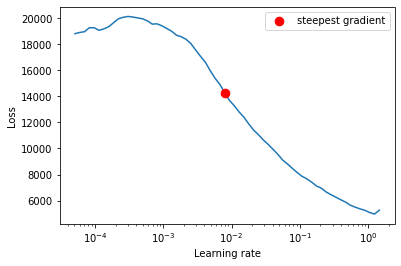

In [23]:
lr_finder.plot()
lr_finder.reset()

In [24]:
7.92E-03

0.00792

#### Continue training

In [32]:
patience_scheduler_overfit = 5
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min',
                                                       factor=0.6, patience = patience_scheduler_overfit,
                                                       threshold=0.0001, threshold_mode='abs')

In [33]:
early_stopping = utils.EarlyStopping(patience=(2*patience_scheduler_overfit)+3, verbose=True,
                               path=os.path.join(saved_models_directory, 'checkpoint_state_dict.pth'))

In [34]:
config = wandb.config
config.model = 'resnext101_32x8d'
config.optimizer =  'AdamW'
config.learning_rate_start = optimizer.param_groups[0]["lr"]
# config.momentum = optimizer.param_groups[0]["momentum"]
config.momentum = None
config.weight_decay = optimizer.param_groups[0]["weight_decay"]
config.scheduler =  'ReduceLROnPlateau'
config.scheduler_factor =  0.6
config.scheduler_patience =  5
config.scheduler_threshold =  0.0001
config.batch_size = BATCH_SIZE

In [35]:
previous_epochs = 0 # how many epochs have been done previously if resuming

In [36]:
for epoch in range(previous_epochs, EPOCHS+previous_epochs):
    # TRAINING Part
    model.train()
    train_loss = []
    mse_train_list = []
    
    bar = tqdm(train_dataloader, position=0, leave=False, desc=f'epoch {epoch} training data')
    i = 0
    for train_data in bar: # for each training step
        i += 1
        img_data_device = train_data['image'].to(device, dtype=torch.float)
        stacked_gt_device = torch.stack((train_data['P'], train_data['K'], train_data['Mg'], train_data['pH'])).transpose(0,1).to(device, dtype=torch.float)
        
        output = model(img_data_device)
        
        loss = loss_func(output, stacked_gt_device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss)
        
        output_cpu = output.detach().cpu().numpy()
        stacked_gt_cpu = stacked_gt_device.cpu().numpy()
        
        # Calculate MSE for each class
        mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
        mse_train_list.append(mse)
        
        if i % 10 == 0: # log every 10 batches
            train_log_dict = dict()
            train_log_dict['batch_number'] = i
            train_log_dict['epoch'] = epoch
            train_log_dict['train_batch_loss'] = loss 
            train_log_dict['train_batch_MSE_P'] = mse[0]
            train_log_dict['train_batch_MSE_K'] = mse[1]
            train_log_dict['train_batch_MSE_Mg'] = mse[2]
            train_log_dict['train_batch_MSE_pH'] = mse[3]
            wandb.log(train_log_dict)
    
    avg_train_loss = torch.stack(train_loss).mean().item()
    avg_train_mse = torch.as_tensor(np.array(mse_train_list)).mean(axis=0).numpy().tolist()
    
    print(f'epoch: {epoch}, LR: {optimizer.param_groups[0]["lr"]}, train loss: {avg_train_loss}, train MSE: {avg_train_mse}')
    wandb.log({'epoch': epoch, 'average_train_loss':avg_train_loss, 'average_train_MSE_P': avg_train_mse[0], 'average_train_MSE_K': avg_train_mse[1],
              'average_train_MSE_Mg': avg_train_mse[2], 'average_train_MSE_pH': avg_train_mse[3]})
    
    # VALIDATION Part
    model.eval()
    val_bar = tqdm(validation_dataloader, position=0, leave=False, desc=f'epoch {epoch} validation data')
    with torch.no_grad():
        val_loss = []
        mse_val_list = []
        for val_data in val_bar:
            img_data_device = val_data['image'].to(device, dtype=torch.float)
            stacked_gt_device = torch.stack((val_data['P'], val_data['K'], val_data['Mg'], val_data['pH'])).transpose(0,1).to(device, dtype=torch.float)
            
            output = model(img_data_device)
            
            loss = loss_func(output, stacked_gt_device)
            val_loss.append(loss)
            
            output_cpu = output.detach().cpu().numpy()
            stacked_gt_cpu = stacked_gt_device.cpu().numpy()

            # Calculate MSE for each class
            mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
            mse_val_list.append(mse)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        avg_val_mse = torch.as_tensor(np.array(mse_val_list)).mean(axis=0).numpy().tolist()
        
        print(f'epoch: {epoch}, validation loss: {avg_val_loss}, validation MSE: {avg_val_mse}')
        wandb.log({'epoch': epoch, 'average_val_loss': avg_val_loss, 'average_val_MSE_P': avg_val_mse[0], 'average_val_MSE_K': avg_val_mse[1], 
                   'average_val_MSE_Mh': avg_val_mse[2], 'average_val_MSE_pH': avg_val_mse[3]})
        
        scheduler.step(avg_val_loss)
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break


epoch 0 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 0, LR: 0.01, train loss: 2223.535400390625, train MSE: [1208.125244140625, 5461.6728515625, 2212.197021484375, 12.146430015563965]


epoch 0 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 0, validation loss: 1735.2301025390625, validation MSE: [1047.169189453125, 4138.65478515625, 1754.959228515625, 0.13631166517734528]
Validation loss decreased (inf --> 1735.230103).  Saving model ...


epoch 1 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 1, LR: 0.01, train loss: 1652.3214111328125, train MSE: [966.388427734375, 3954.3134765625, 1688.31298828125, 0.2704840302467346]


epoch 1 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 1, validation loss: 1686.26318359375, validation MSE: [1124.8309326171875, 3850.732421875, 1769.406494140625, 0.08221926540136337]
Validation loss decreased (1735.230103 --> 1686.263184).  Saving model ...


epoch 2 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 2, LR: 0.01, train loss: 1638.538818359375, train MSE: [965.2699584960938, 3928.85302734375, 1659.9124755859375, 0.11977026611566544]


epoch 2 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 2, validation loss: 1723.4193115234375, validation MSE: [1174.9659423828125, 3984.10009765625, 1734.465576171875, 0.1453123688697815]
EarlyStopping counter: 1 out of 13


epoch 3 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 3, LR: 0.01, train loss: 1645.2803955078125, train MSE: [962.9523315429688, 3956.659423828125, 1661.2982177734375, 0.2109660506248474]


epoch 3 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 3, validation loss: 1923.28125, validation MSE: [1360.3582763671875, 4652.01171875, 1680.656982421875, 0.09807821363210678]
EarlyStopping counter: 2 out of 13


epoch 4 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 4, LR: 0.01, train loss: 1651.1544189453125, train MSE: [962.7039794921875, 3954.991455078125, 1686.7630615234375, 0.15813714265823364]


epoch 4 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 4, validation loss: 1809.3277587890625, validation MSE: [1228.064697265625, 4314.20361328125, 1694.9398193359375, 0.10245507210493088]
EarlyStopping counter: 3 out of 13


epoch 5 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 5, LR: 0.01, train loss: 1642.9072265625, train MSE: [959.5758056640625, 3945.270751953125, 1666.65771484375, 0.12461365759372711]


epoch 5 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 5, validation loss: 1746.60302734375, validation MSE: [1073.20263671875, 4188.087890625, 1725.0601806640625, 0.06200197711586952]
EarlyStopping counter: 4 out of 13


epoch 6 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 6, LR: 0.01, train loss: 1634.900634765625, train MSE: [952.1830444335938, 3937.23388671875, 1650.0595703125, 0.12590572237968445]


epoch 6 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 6, validation loss: 1835.2216796875, validation MSE: [1056.1591796875, 4578.3212890625, 1706.2593994140625, 0.14671851694583893]
EarlyStopping counter: 5 out of 13


epoch 7 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 7, LR: 0.01, train loss: 1626.2794189453125, train MSE: [945.0438842773438, 3913.580810546875, 1646.3673095703125, 0.12474130094051361]


epoch 7 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 7, validation loss: 1679.602783203125, validation MSE: [950.8504028320312, 3962.730712890625, 1804.7322998046875, 0.09661617875099182]
Validation loss decreased (1686.263184 --> 1679.602783).  Saving model ...


epoch 8 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 8, LR: 0.01, train loss: 1637.2548828125, train MSE: [943.3964233398438, 3913.590087890625, 1691.876708984375, 0.1556856781244278]


epoch 8 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 8, validation loss: 1695.7325439453125, validation MSE: [940.1678466796875, 4123.783203125, 1718.9169921875, 0.062106236815452576]
EarlyStopping counter: 1 out of 13


epoch 9 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 9, LR: 0.01, train loss: 1629.3345947265625, train MSE: [940.3138427734375, 3914.392333984375, 1662.5001220703125, 0.13178592920303345]


epoch 9 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 9, validation loss: 1670.130859375, validation MSE: [920.2183227539062, 3996.2431640625, 1763.8458251953125, 0.21580873429775238]
Validation loss decreased (1679.602783 --> 1670.130859).  Saving model ...


epoch 10 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 10, LR: 0.01, train loss: 1637.781494140625, train MSE: [935.309814453125, 3960.823974609375, 1654.809814453125, 0.18244023621082306]


epoch 10 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 10, validation loss: 1693.9473876953125, validation MSE: [922.5852661132812, 4150.09326171875, 1702.95654296875, 0.1534537523984909]
EarlyStopping counter: 1 out of 13


epoch 11 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 11, LR: 0.01, train loss: 1643.6387939453125, train MSE: [941.6126708984375, 3959.262939453125, 1673.4443359375, 0.23535285890102386]


epoch 11 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 11, validation loss: 1627.3385009765625, validation MSE: [854.48876953125, 3909.6650390625, 1745.046630859375, 0.15376317501068115]
Validation loss decreased (1670.130859 --> 1627.338501).  Saving model ...


epoch 12 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 12, LR: 0.01, train loss: 1626.612060546875, train MSE: [939.0527954101562, 3939.0283203125, 1628.1224365234375, 0.2444065511226654]


epoch 12 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 12, validation loss: 1836.808349609375, validation MSE: [1098.7442626953125, 4507.958984375, 1740.0406494140625, 0.48929768800735474]
EarlyStopping counter: 1 out of 13


epoch 13 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 13, LR: 0.01, train loss: 1638.875244140625, train MSE: [932.4758911132812, 3945.010009765625, 1677.865966796875, 0.14852522313594818]


epoch 13 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 13, validation loss: 1680.118408203125, validation MSE: [866.4839477539062, 4117.19140625, 1736.487548828125, 0.31069138646125793]
EarlyStopping counter: 2 out of 13


epoch 14 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 14, LR: 0.01, train loss: 1633.703125, train MSE: [928.0122680664062, 3932.852294921875, 1673.81103515625, 0.1364680677652359]


epoch 14 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 14, validation loss: 1739.3232421875, validation MSE: [864.029541015625, 4397.494140625, 1695.275146484375, 0.49357300996780396]
EarlyStopping counter: 3 out of 13


epoch 15 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 15, LR: 0.01, train loss: 1620.882080078125, train MSE: [925.49462890625, 3895.421875, 1662.49462890625, 0.11731640249490738]


epoch 15 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 15, validation loss: 1768.435546875, validation MSE: [866.3944091796875, 4524.9443359375, 1682.2647705078125, 0.13829343020915985]
EarlyStopping counter: 4 out of 13


epoch 16 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 16, LR: 0.01, train loss: 1614.698974609375, train MSE: [922.521484375, 3883.070556640625, 1653.0902099609375, 0.11298369616270065]


epoch 16 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 16, validation loss: 1765.309326171875, validation MSE: [873.6170654296875, 4507.4775390625, 1680.0406494140625, 0.10220646113157272]
EarlyStopping counter: 5 out of 13


epoch 17 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 17, LR: 0.01, train loss: 1615.1888427734375, train MSE: [924.353759765625, 3880.623291015625, 1655.6702880859375, 0.10822637379169464]


epoch 17 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 17, validation loss: 1643.00830078125, validation MSE: [831.3330688476562, 3967.236328125, 1773.3648681640625, 0.09819983690977097]
EarlyStopping counter: 6 out of 13


epoch 18 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 18, LR: 0.006, train loss: 1587.454833984375, train MSE: [896.7329711914062, 3837.72705078125, 1615.2625732421875, 0.0962129756808281]


epoch 18 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 18, validation loss: 1605.0601806640625, validation MSE: [924.773681640625, 3768.166015625, 1727.23291015625, 0.06780969351530075]
Validation loss decreased (1627.338501 --> 1605.060181).  Saving model ...


epoch 19 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 19, LR: 0.006, train loss: 1587.3792724609375, train MSE: [902.0635986328125, 3834.830078125, 1612.53369140625, 0.08950068801641464]


epoch 19 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 19, validation loss: 1670.720458984375, validation MSE: [847.7308959960938, 3833.0947265625, 2001.839111328125, 0.21704056859016418]
EarlyStopping counter: 1 out of 13


epoch 20 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 20, LR: 0.006, train loss: 1586.3472900390625, train MSE: [903.1881713867188, 3830.434814453125, 1611.6781005859375, 0.08765395730733871]


epoch 20 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 20, validation loss: 1604.5133056640625, validation MSE: [926.7413330078125, 3794.277099609375, 1696.9658203125, 0.06913897395133972]
Validation loss decreased (1605.060181 --> 1604.513306).  Saving model ...


epoch 21 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 21, LR: 0.006, train loss: 1597.90869140625, train MSE: [904.5302124023438, 3861.212890625, 1625.797607421875, 0.09352514892816544]


epoch 21 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 21, validation loss: 1626.5599365234375, validation MSE: [938.111083984375, 3843.259521484375, 1724.7877197265625, 0.08132422715425491]
EarlyStopping counter: 1 out of 13


epoch 22 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 22, LR: 0.006, train loss: 1589.29345703125, train MSE: [903.2503662109375, 3838.240478515625, 1615.5899658203125, 0.09319236129522324]


epoch 22 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 22, validation loss: 1587.369140625, validation MSE: [915.81884765625, 3736.913818359375, 1696.681396484375, 0.06251664459705353]
Validation loss decreased (1604.513306 --> 1587.369141).  Saving model ...


epoch 23 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 23, LR: 0.006, train loss: 1579.7803955078125, train MSE: [901.4307861328125, 3806.413818359375, 1611.18212890625, 0.09505963325500488]


epoch 23 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 23, validation loss: 1578.8408203125, validation MSE: [916.2772216796875, 3710.71533203125, 1688.3009033203125, 0.06971320509910583]
Validation loss decreased (1587.369141 --> 1578.840820).  Saving model ...


epoch 24 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 24, LR: 0.006, train loss: 1597.9239501953125, train MSE: [908.931884765625, 3861.86474609375, 1620.79736328125, 0.1012663021683693]


epoch 24 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 24, validation loss: 1650.532470703125, validation MSE: [933.5352172851562, 3854.0244140625, 1814.4962158203125, 0.07313752919435501]
EarlyStopping counter: 1 out of 13


epoch 25 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 25, LR: 0.006, train loss: 1591.9510498046875, train MSE: [902.986328125, 3856.565673828125, 1608.137939453125, 0.1142939105629921]


epoch 25 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 25, validation loss: 1591.5194091796875, validation MSE: [909.3528442382812, 3753.920654296875, 1702.7349853515625, 0.06906209886074066]
EarlyStopping counter: 2 out of 13


epoch 26 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 26, LR: 0.006, train loss: 1587.2100830078125, train MSE: [903.8676147460938, 3834.398193359375, 1610.460205078125, 0.11407707631587982]


epoch 26 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 26, validation loss: 1610.740478515625, validation MSE: [881.6270141601562, 3884.773681640625, 1676.3419189453125, 0.2187269777059555]
EarlyStopping counter: 3 out of 13


epoch 27 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 27, LR: 0.006, train loss: 1583.67138671875, train MSE: [905.241943359375, 3816.060302734375, 1613.262939453125, 0.1198110431432724]


epoch 27 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 27, validation loss: 1625.7274169921875, validation MSE: [932.9074096679688, 3832.917724609375, 1737.01904296875, 0.06498503684997559]
EarlyStopping counter: 4 out of 13


epoch 28 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 28, LR: 0.006, train loss: 1577.103271484375, train MSE: [904.363037109375, 3798.2158203125, 1605.71630859375, 0.11754083633422852]


epoch 28 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 28, validation loss: 1751.8043212890625, validation MSE: [835.028076171875, 4448.5810546875, 1723.3101806640625, 0.2982179820537567]
EarlyStopping counter: 5 out of 13


epoch 29 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 29, LR: 0.006, train loss: 1568.2589111328125, train MSE: [902.2456665039062, 3772.739990234375, 1597.9305419921875, 0.11864383518695831]


epoch 29 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 29, validation loss: 1606.0977783203125, validation MSE: [934.0536499023438, 3731.673095703125, 1758.5572509765625, 0.10692303627729416]
EarlyStopping counter: 6 out of 13


epoch 30 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 30, LR: 0.0036, train loss: 1543.5908203125, train MSE: [897.4139404296875, 3711.645751953125, 1565.223876953125, 0.07970721274614334]


epoch 30 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 30, validation loss: 1554.1328125, validation MSE: [868.7010498046875, 3702.25048828125, 1645.5185546875, 0.06061181426048279]
Validation loss decreased (1578.840820 --> 1554.132812).  Saving model ...


epoch 31 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 31, LR: 0.0036, train loss: 1540.849853515625, train MSE: [894.7302856445312, 3716.931396484375, 1551.6593017578125, 0.07823345065116882]


epoch 31 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 31, validation loss: 1548.46728515625, validation MSE: [868.159423828125, 3690.41845703125, 1635.2303466796875, 0.06040560454130173]
Validation loss decreased (1554.132812 --> 1548.467285).  Saving model ...


epoch 32 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 32, LR: 0.0036, train loss: 1529.6072998046875, train MSE: [893.0814819335938, 3673.550048828125, 1551.71923828125, 0.07843732833862305]


epoch 32 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 32, validation loss: 1559.685791015625, validation MSE: [881.001708984375, 3706.99951171875, 1650.6741943359375, 0.06805122643709183]
EarlyStopping counter: 1 out of 13


epoch 33 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 33, LR: 0.0036, train loss: 1556.041259765625, train MSE: [896.6493530273438, 3777.77392578125, 1549.6636962890625, 0.07777407765388489]


epoch 33 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 33, validation loss: 1557.8145751953125, validation MSE: [881.9324340820312, 3708.0693359375, 1641.1904296875, 0.06594089418649673]
EarlyStopping counter: 2 out of 13


epoch 34 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 34, LR: 0.0036, train loss: 1535.679931640625, train MSE: [893.6019897460938, 3696.669189453125, 1552.366455078125, 0.08167603611946106]


epoch 34 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 34, validation loss: 1552.3192138671875, validation MSE: [884.2450561523438, 3685.18701171875, 1639.7733154296875, 0.07076316326856613]
EarlyStopping counter: 3 out of 13


epoch 35 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 35, LR: 0.0036, train loss: 1531.0347900390625, train MSE: [892.583984375, 3677.842041015625, 1553.628173828125, 0.08475972712039948]


epoch 35 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 35, validation loss: 1547.64501953125, validation MSE: [885.6268310546875, 3653.92041015625, 1650.9720458984375, 0.06048094853758812]
Validation loss decreased (1548.467285 --> 1547.645020).  Saving model ...


epoch 36 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 36, LR: 0.0036, train loss: 1540.1763916015625, train MSE: [893.4616088867188, 3715.7666015625, 1551.392822265625, 0.08524373173713684]


epoch 36 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 36, validation loss: 1555.317138671875, validation MSE: [889.5651245117188, 3680.317626953125, 1651.32421875, 0.06120094284415245]
EarlyStopping counter: 1 out of 13


epoch 37 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 37, LR: 0.0036, train loss: 1560.6488037109375, train MSE: [895.6680297851562, 3784.67236328125, 1562.161865234375, 0.09260696172714233]


epoch 37 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 37, validation loss: 1560.3770751953125, validation MSE: [874.94384765625, 3699.43798828125, 1667.06591796875, 0.059693749994039536]
EarlyStopping counter: 2 out of 13


epoch 38 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 38, LR: 0.0036, train loss: 1546.9224853515625, train MSE: [892.792236328125, 3733.65625, 1561.1470947265625, 0.09477902203798294]


epoch 38 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 38, validation loss: 1540.55322265625, validation MSE: [896.7882080078125, 3605.384765625, 1659.976806640625, 0.06291326880455017]
Validation loss decreased (1547.645020 --> 1540.553223).  Saving model ...


epoch 39 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 39, LR: 0.0036, train loss: 1546.964111328125, train MSE: [894.43896484375, 3737.9228515625, 1555.38818359375, 0.10661079734563828]


epoch 39 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 39, validation loss: 1553.96337890625, validation MSE: [896.9813842773438, 3619.42822265625, 1699.38427734375, 0.05974894016981125]
EarlyStopping counter: 1 out of 13


epoch 40 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 40, LR: 0.0036, train loss: 1529.5625, train MSE: [889.9798583984375, 3665.6455078125, 1562.5174560546875, 0.10712947696447372]


epoch 40 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 40, validation loss: 1528.2999267578125, validation MSE: [897.0791625976562, 3574.252197265625, 1641.8055419921875, 0.06230363994836807]
Validation loss decreased (1540.553223 --> 1528.299927).  Saving model ...


epoch 41 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 41, LR: 0.0036, train loss: 1526.2960205078125, train MSE: [891.7291259765625, 3651.583251953125, 1561.7581787109375, 0.11312931776046753]


epoch 41 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 41, validation loss: 1534.8614501953125, validation MSE: [881.3316040039062, 3591.342041015625, 1666.710693359375, 0.06175219640135765]
EarlyStopping counter: 1 out of 13


epoch 42 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 42, LR: 0.0036, train loss: 1543.9266357421875, train MSE: [893.6143188476562, 3716.89013671875, 1565.0806884765625, 0.1206321269273758]


epoch 42 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 42, validation loss: 1557.3704833984375, validation MSE: [874.0231323242188, 3682.046875, 1673.3292236328125, 0.08234885334968567]
EarlyStopping counter: 2 out of 13


epoch 43 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 43, LR: 0.0036, train loss: 1549.1910400390625, train MSE: [894.6180419921875, 3747.783203125, 1554.245849609375, 0.11700895428657532]


epoch 43 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 43, validation loss: 1541.1180419921875, validation MSE: [880.8666381835938, 3642.15576171875, 1641.3839111328125, 0.06584124267101288]
EarlyStopping counter: 3 out of 13


epoch 44 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 44, LR: 0.0036, train loss: 1536.4337158203125, train MSE: [893.1692504882812, 3696.611328125, 1555.83740234375, 0.11681993305683136]


epoch 44 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 44, validation loss: 1555.875244140625, validation MSE: [882.0331420898438, 3684.157958984375, 1657.24658203125, 0.06332262605428696]
EarlyStopping counter: 4 out of 13


epoch 45 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 45, LR: 0.0036, train loss: 1531.1368408203125, train MSE: [890.9758911132812, 3672.517822265625, 1560.935791015625, 0.11773046106100082]


epoch 45 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 45, validation loss: 1565.5506591796875, validation MSE: [828.3777465820312, 3678.213623046875, 1755.518798828125, 0.09244345128536224]
EarlyStopping counter: 5 out of 13


epoch 46 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 46, LR: 0.0036, train loss: 1513.0201416015625, train MSE: [887.4483032226562, 3597.5498046875, 1566.96484375, 0.11775311827659607]


epoch 46 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 46, validation loss: 1585.1802978515625, validation MSE: [894.5179443359375, 3702.176513671875, 1743.9381103515625, 0.08841806650161743]
EarlyStopping counter: 6 out of 13


epoch 47 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 47, LR: 0.00216, train loss: 1502.1898193359375, train MSE: [884.1204833984375, 3576.220947265625, 1548.3372802734375, 0.08021274954080582]


epoch 47 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 47, validation loss: 1580.2110595703125, validation MSE: [846.81005859375, 3801.917236328125, 1672.0367431640625, 0.07972065359354019]
EarlyStopping counter: 7 out of 13


epoch 48 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 48, LR: 0.00216, train loss: 1489.069091796875, train MSE: [879.387451171875, 3541.25146484375, 1535.5596923828125, 0.07821904122829437]


epoch 48 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 48, validation loss: 1559.035400390625, validation MSE: [864.8162841796875, 3708.871337890625, 1662.3836669921875, 0.07046109437942505]
EarlyStopping counter: 8 out of 13


epoch 49 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 49, LR: 0.00216, train loss: 1466.2518310546875, train MSE: [878.6082763671875, 3448.166015625, 1538.14599609375, 0.08649963140487671]


epoch 49 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 49, validation loss: 1620.6473388671875, validation MSE: [850.5440063476562, 3887.3466796875, 1744.6219482421875, 0.07647418975830078]
EarlyStopping counter: 9 out of 13


epoch 50 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 50, LR: 0.00216, train loss: 1458.8114013671875, train MSE: [878.9686279296875, 3419.26318359375, 1536.9346923828125, 0.0792241096496582]


epoch 50 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 50, validation loss: 1517.8555908203125, validation MSE: [873.876220703125, 3511.402099609375, 1686.0751953125, 0.06771839410066605]
Validation loss decreased (1528.299927 --> 1517.855591).  Saving model ...


epoch 51 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 51, LR: 0.00216, train loss: 1446.0721435546875, train MSE: [876.5929565429688, 3373.966552734375, 1533.6458740234375, 0.08334257453680038]


epoch 51 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 51, validation loss: 1547.898681640625, validation MSE: [864.9246215820312, 3655.9970703125, 1670.599853515625, 0.07243982702493668]
EarlyStopping counter: 1 out of 13


epoch 52 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 52, LR: 0.00216, train loss: 1431.78369140625, train MSE: [879.7855834960938, 3321.002685546875, 1526.2598876953125, 0.08644281327724457]


epoch 52 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 52, validation loss: 1557.8544921875, validation MSE: [920.9519653320312, 3666.4033203125, 1643.9849853515625, 0.07750341296195984]
EarlyStopping counter: 2 out of 13


epoch 53 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 53, LR: 0.00216, train loss: 1480.5006103515625, train MSE: [881.5079956054688, 3509.58154296875, 1530.82861328125, 0.08459879457950592]


epoch 53 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 53, validation loss: 1498.7725830078125, validation MSE: [862.5536499023438, 3477.545654296875, 1654.91552734375, 0.07473942637443542]
Validation loss decreased (1517.855591 --> 1498.772583).  Saving model ...


epoch 54 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 54, LR: 0.00216, train loss: 1446.2115478515625, train MSE: [875.8054809570312, 3381.286376953125, 1527.66845703125, 0.08607473969459534]


epoch 54 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 54, validation loss: 1507.0521240234375, validation MSE: [862.038330078125, 3513.388916015625, 1652.70947265625, 0.07118136435747147]
EarlyStopping counter: 1 out of 13


epoch 55 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 55, LR: 0.00216, train loss: 1437.9351806640625, train MSE: [883.2325439453125, 3350.51025390625, 1517.911376953125, 0.08656516671180725]


epoch 55 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 55, validation loss: 1581.9239501953125, validation MSE: [890.5296630859375, 3777.594970703125, 1659.4991455078125, 0.07182768732309341]
EarlyStopping counter: 2 out of 13


epoch 56 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 56, LR: 0.00216, train loss: 1424.3115234375, train MSE: [878.529052734375, 3306.421142578125, 1512.2093505859375, 0.08677681535482407]


epoch 56 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 56, validation loss: 1548.5078125, validation MSE: [880.7901611328125, 3659.938720703125, 1653.2177734375, 0.08398208767175674]
EarlyStopping counter: 3 out of 13


epoch 57 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 57, LR: 0.00216, train loss: 1398.7763671875, train MSE: [874.9518432617188, 3210.254638671875, 1509.8095703125, 0.08997879177331924]


epoch 57 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 57, validation loss: 1587.778076171875, validation MSE: [891.912353515625, 3814.15576171875, 1644.9505615234375, 0.0934169590473175]
EarlyStopping counter: 4 out of 13


epoch 58 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 58, LR: 0.00216, train loss: 1409.321533203125, train MSE: [877.094482421875, 3256.44873046875, 1503.650146484375, 0.09243199229240417]


epoch 58 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 58, validation loss: 1508.1085205078125, validation MSE: [890.5377807617188, 3508.8896484375, 1632.932861328125, 0.07330211997032166]
EarlyStopping counter: 5 out of 13


epoch 59 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 59, LR: 0.00216, train loss: 1384.880126953125, train MSE: [878.5695190429688, 3157.49169921875, 1503.3685302734375, 0.0904068723320961]


epoch 59 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 59, validation loss: 1562.816650390625, validation MSE: [939.5897827148438, 3682.28955078125, 1629.2989501953125, 0.08847104012966156]
EarlyStopping counter: 6 out of 13


epoch 60 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 60, LR: 0.001296, train loss: 1353.5045166015625, train MSE: [873.4003295898438, 3050.4619140625, 1490.073974609375, 0.08162303268909454]


epoch 60 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 60, validation loss: 1556.7498779296875, validation MSE: [884.7987670898438, 3684.260498046875, 1657.87109375, 0.06909359991550446]
EarlyStopping counter: 7 out of 13


epoch 61 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 61, LR: 0.001296, train loss: 1327.3687744140625, train MSE: [865.724853515625, 2954.848876953125, 1488.8233642578125, 0.0783306285738945]


epoch 61 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 61, validation loss: 1555.66845703125, validation MSE: [879.0289306640625, 3687.229736328125, 1656.3408203125, 0.07320961356163025]
EarlyStopping counter: 8 out of 13


epoch 62 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 62, LR: 0.001296, train loss: 1304.348876953125, train MSE: [866.6279907226562, 2871.375244140625, 1479.3135986328125, 0.07855328172445297]


epoch 62 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 62, validation loss: 1563.510986328125, validation MSE: [893.9619750976562, 3700.7626953125, 1659.24072265625, 0.07833021134138107]
EarlyStopping counter: 9 out of 13


epoch 63 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 63, LR: 0.001296, train loss: 1278.59521484375, train MSE: [864.37255859375, 2775.106689453125, 1474.82275390625, 0.07846750319004059]


epoch 63 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 63, validation loss: 1579.689453125, validation MSE: [899.5394897460938, 3763.739013671875, 1655.4071044921875, 0.07193788141012192]
EarlyStopping counter: 10 out of 13


epoch 64 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 64, LR: 0.001296, train loss: 1261.755126953125, train MSE: [863.7635498046875, 2712.43310546875, 1470.7462158203125, 0.07730415463447571]


epoch 64 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 64, validation loss: 1542.4774169921875, validation MSE: [881.3091430664062, 3651.4248046875, 1637.0599365234375, 0.11516908556222916]
EarlyStopping counter: 11 out of 13


epoch 65 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 65, LR: 0.001296, train loss: 1266.0379638671875, train MSE: [862.5720825195312, 2724.56787109375, 1476.9344482421875, 0.07820341736078262]


epoch 65 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 65, validation loss: 1570.5218505859375, validation MSE: [890.5308227539062, 3742.136962890625, 1649.3546142578125, 0.06465886533260345]
EarlyStopping counter: 12 out of 13


epoch 66 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 66, LR: 0.0007776, train loss: 1244.6807861328125, train MSE: [860.5742797851562, 2650.6142578125, 1467.458251953125, 0.07555858045816422]


epoch 66 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 66, validation loss: 1582.10302734375, validation MSE: [891.0718994140625, 3769.025634765625, 1668.2449951171875, 0.0695890262722969]
EarlyStopping counter: 13 out of 13
Early stopping


In [38]:
torch.save(model.state_dict(), os.path.join(saved_models_directory, model_name+f'_EPOCHS_{epoch}.pth'))

In [39]:
# rename checkpoint.pth
! mv saved_models/checkpoint_state_dict.pth saved_models/checkpoint_state_dict_resNext100_01_03_2022.pth

In [12]:
# load saved model
modelLoad = ResNext(False)
modelLoad.load_state_dict(torch.load(os.path.join(saved_models_directory, 'checkpoint_state_dict_resNext100_01_03_2022.pth')))

<All keys matched successfully>

In [13]:
modelLoad = modelLoad.to(device)

### Predict test dataset

In [14]:
modelLoad.eval()

ResNext(
  (resnext): ResNet(
    (conv1): Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seq

In [15]:
test_data = HyperViewDataset(None, os.path.join(test_data_directory), True, means, stds)

In [16]:
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, pin_memory=True, drop_last=False, num_workers=2)

In [17]:
len(test_data)

1154

In [18]:
output_list = []
bar = tqdm(test_dataloader, position=0, leave=False, desc=f'test data')
for test_data in bar: # for each test step
        img_data_device = test_data['image'].to(device, dtype=torch.float)
        
        output = modelLoad(img_data_device)
        output_cpu = output.detach().cpu().numpy()
        output_list.append(output_cpu)
        

test data:   0%|          | 0/97 [00:00<?, ?it/s]

In [19]:
submission = pd.DataFrame(data = [item for sublist in output_list for item in sublist], columns=["P", "K", "Mg", "pH"])
submission

P           K          Mg        pH
0     75.287346  216.349579  160.704834  6.973335
1     75.283966  216.334991  160.703293  6.973049
2     75.279747  216.318329  160.700775  6.972764
3     75.277786  216.309708  160.700058  6.972622
4     75.278320  216.309860  160.701431  6.972644
...         ...         ...         ...       ...
1149  66.811943  193.150421  159.566956  6.553332
1150  64.733612  183.916061  158.808426  6.484830
1151  66.849800  193.201859  160.219910  6.528639
1152  66.101166  190.020508  159.956726  6.510277
1153  83.744919  267.101532  158.369583  7.031000

[1154 rows x 4 columns]

In [20]:
submission.to_csv(os.path.join(submissions_directory, "submission_01_03_2022_ResNext100_Checkpoint.csv"), index_label="sample_index")